[*********************100%***********************]  1 of 1 completed


Price     Close      High       Low      Open     Volume
0      1.592667  1.666667  1.169333  1.266667  281494500
1      1.588667  2.028000  1.553333  1.719333  257806500
2      1.464000  1.728000  1.351333  1.666667  123282000
3      1.280000  1.540000  1.247333  1.533333   77097000
4      1.074000  1.333333  1.055333  1.333333  103003500
Index(['Volume', 'Open', 'Close', 'MACD_HIST', 'MFI', 'BB', 'RSI', 'Target'], dtype='object', name='Price')
Optimization terminated successfully.
         Current function value: 0.691790
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:                 Target   No. Observations:                 3850
Model:                          Logit   Df Residuals:                     3842
Method:                           MLE   Df Model:                            7
Date:                Mon, 22 Dec 2025   Pseudo R-squ.:                0.001085
Time:                        12:42:32   Log-Likelihoo

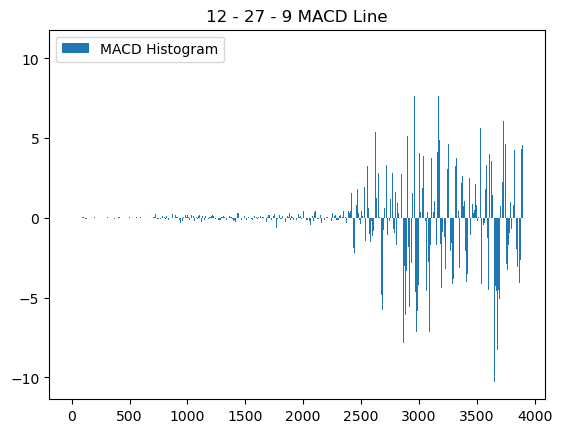

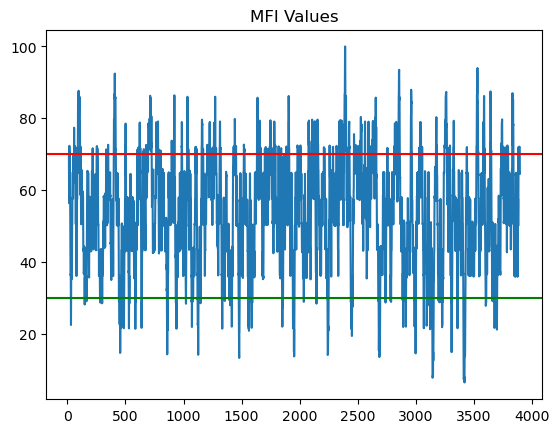

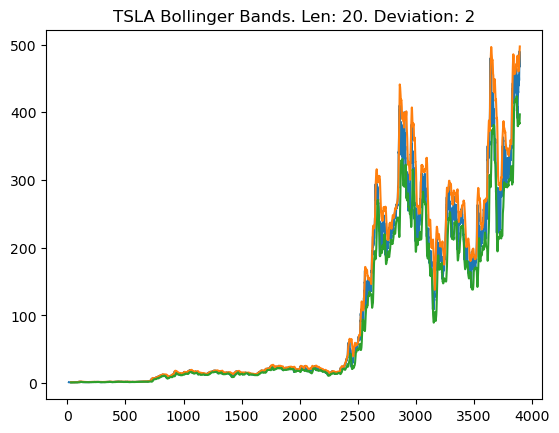

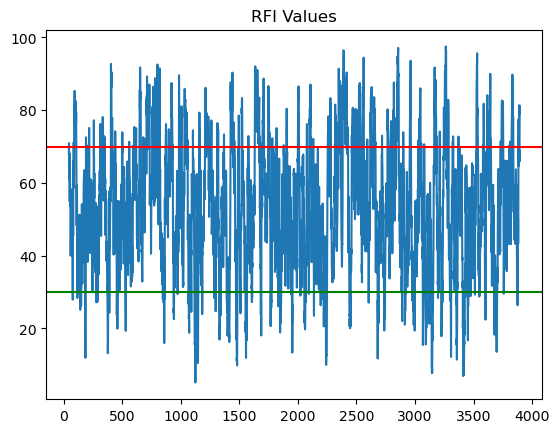

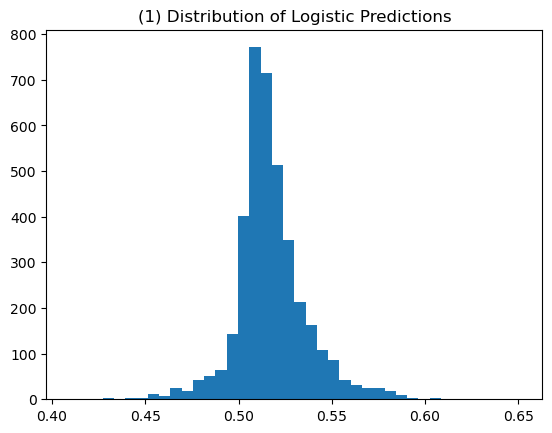

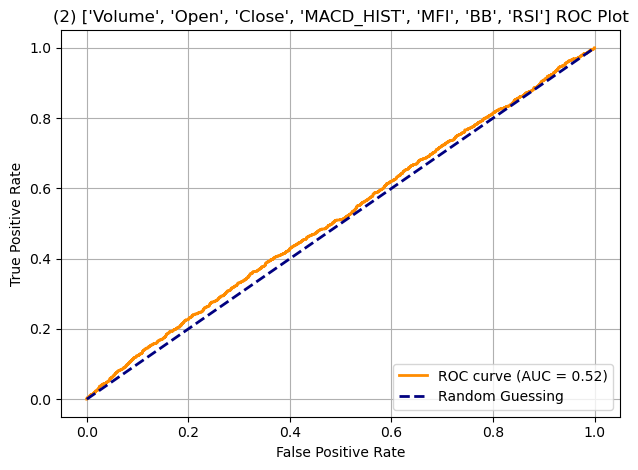

Price,Close,High,Low,Open,Volume,12_ema,27_ema,MACD,Signal,MACD_HIST,...,Lower Band,BB,gain,loss,avg_gain,avg_loss,RSI,Close + 1,Target,Prediction
45,1.363333,1.379333,1.306667,1.308000,7423500,1.310333,1.308004,0.002330,-0.006799,0.009128,...,1.182168,0.120830,0.064666,-0.000000,0.019191,0.009048,67.959406,1.404000,1,1
46,1.404000,1.416000,1.354000,1.358000,7306500,1.324749,1.315078,0.009671,-0.003504,0.013176,...,1.176399,-0.026764,0.040667,-0.000000,0.022095,0.009048,70.947910,1.403333,0,1
47,1.403333,1.420000,1.377333,1.391333,6519000,1.336843,1.321567,0.015276,0.000252,0.015024,...,1.169838,0.045104,0.000000,0.000667,0.019905,0.009095,68.636923,1.369333,0,1
48,1.369333,1.400000,1.366667,1.374000,3651000,1.341843,1.325072,0.016771,0.003556,0.013216,...,1.168278,0.208167,0.000000,0.034000,0.018143,0.011524,61.155550,1.393333,1,1
49,1.393333,1.396667,1.373333,1.377333,4326000,1.349766,1.330070,0.019696,0.006784,0.012912,...,1.167932,0.156021,0.024000,-0.000000,0.019857,0.009714,67.149673,1.380667,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3890,475.309998,481.769989,467.660004,469.440002,114542200,447.866473,438.674732,9.191741,4.601195,4.590546,...,384.640612,0.029867,16.350006,-0.000000,5.602859,1.493574,78.953176,489.880005,1,1
3891,489.880005,491.500000,465.829987,472.209991,107608100,454.330093,442.332252,11.997842,6.080524,5.917317,...,383.176157,-0.021229,14.570007,-0.000000,6.527860,1.493574,81.380214,467.260010,0,1
3892,467.260010,495.279999,466.200012,488.220001,106490400,456.319311,444.112806,12.206505,7.305721,4.900785,...,387.230702,0.222847,0.000000,22.619995,6.015004,3.109288,65.922967,483.369995,1,1
3893,483.369995,490.859985,473.119995,478.160004,95168400,460.480955,446.916891,13.564064,8.557389,5.006675,...,390.242687,0.112157,16.109985,-0.000000,6.909286,3.109288,68.964768,481.200012,0,1


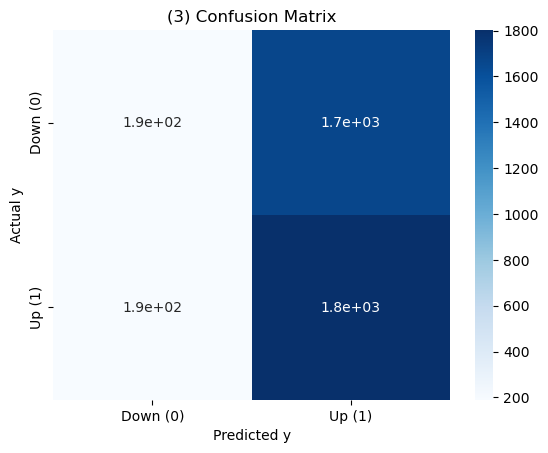

In [ ]:
# Logistic Regression w/ all four Indicators

import numpy as np 
import pandas as pd
from pandas.plotting import lag_plot
import yfinance as yf
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc # pip install scikit-learn
import yfinance_fix

TICKER = "TSLA"
INTERVAL = "1d"
if INTERVAL == "1h":
    PERIOD = "730d"
else: 
    PERIOD = "max"

#   MACD
MACD_FAST = 12
MACD_SLOW = 27
MACD_SPAN = 9
#   MFI
MFI_LENGTH = 14 
OVERBROUGHT = 70
OVERSOLD = 30 
#   BB
BB_LENGTH = 20
STD_DEV = 2
#   RSI
RSI_LENGTH = 14
RSI_OVERBROUGHT = 70
RSI_OVERSOLD = 30

STRATEGY = ["Volume", "Open", "Close", "MACD_HIST", "MFI", "BB", "RSI"]
SHIFT = 1 
LOOKBACK = 10000

def get_data(ticker = TICKER, interval = INTERVAL, lookback = LOOKBACK):

    df = yf.download(ticker, session=yfinance_fix.chrome_session, interval = interval, period = PERIOD)

    # WICHTIG: Prüfen, ob überhaupt Daten da sind!
    if df.empty:
        print(f"WARNUNG: Keine Daten für {ticker} erhalten!")
        return df # Gibt leeren DF zurück, damit main() das abfangen kann
    
    df.columns = df.columns.get_level_values(0)
    df = df.reset_index(drop=True)
    print(df.head())
    
    return df.iloc[-lookback:, :]

# --- (2) Unabhängige Variablen ("Features") definieren ---

def add_MACD(df, fast = MACD_FAST, slow = MACD_SLOW, span = MACD_SPAN):

    # Step 1: Fast and Slow EMA Columns
    df[f"{fast}_ema"] = df["Close"].ewm(span = fast).mean()
    df[f"{slow}_ema"] = df["Close"].ewm(span = slow).mean()

    # Step 2: MACD Column (= Difference betwenn fast and slow ema)
    df["MACD"] = df[f"{fast}_ema"] - df[f"{slow}_ema"]

    # Step 3: MACD Signal (= Span Period)
    df["Signal"] = df[f"MACD"].ewm(span = span).mean()

    # Step 4: MACD Hist
    df["MACD_HIST"] = df[f"MACD"] - df["Signal"]

    # Step 5: Plot Histogram
    plt.figure()
    plt.bar(x=range(len(df)), height=df["MACD_HIST"])
        # Every Bar = Every Date in the Index
        # Direction: Bar (>0) --> Bullish vs. Bar (<0) --> Bearish
        # Strength: Bar (Tall) --> Strong Momentum vs. Bar (Short) --> Weak Momentum
    plt.title(f"{MACD_FAST} - {MACD_SLOW} - {MACD_SPAN} MACD Line")
    plt.legend(["MACD Histogram"])

    return df

def add_MFI(df, length = MFI_LENGTH):
        # Step 1: Build the MFI Index
    df["Average_Price"] = (df["High"]+df["Low"]+df["Close"])/3
    df["Money_Flow"] = df["Volume"]*df["Average_Price"]
    # 14 Period Positive & Negative Money Flow
    df["Pos_Flow"] = np.where(df["Average_Price"].diff()>0, df["Average_Price"], 0)
        # diff() == Delta == Change in Prices from One Day to the next
    df["Neg_Flow"] = np.where(df["Average_Price"].diff()<0, df["Average_Price"], 0)
    # Money Flow Ratio - Rolling Average 
    df["MFR"] = df["Pos_Flow"].rolling(window=length).sum() / df["Neg_Flow"].rolling(window=length).sum()
    df["MFI"] = (100 - 100 / (1 + df["MFR"]))

        # Step 2: Plot the MFI Index
    plt.figure()
    plt.plot(df["MFI"])
    plt.title("MFI Values")
        # Step 3: Draw Overbought & Oversold lines
    plt.axhline(OVERBROUGHT, color="red")
    # When the indicator line is above the red line --> asset overbought/overvalued     
    # Short Signal (Sell) triggered when the indicator line crosses above the red line
    plt.axhline(OVERSOLD, color="green")
    # When the indicator line is below this green line --> asset oversold/undervalued 
    # Long Signal (Buy) triggered when the indicator line crosses above the green line

    return df.dropna()

def add_BB(df, std_dev = STD_DEV, length = BB_LENGTH):

    # Step 1: Middle Bend Column
    df["BB_SMA"] = df["Close"].rolling(window=length).mean()
        # rolling(window=length): it takes the Close price and creates a moving window of length periods
        # mean(): it calculates the average price within that window at each step

    # Step 2: Std Deviation Column
    df["BB_STD"] = df["Close"].rolling(window=length).std()
        # std. dev/volatility: quantifies how spread out/ inconsistent your data is. 
        # It measures the average distance of each data point from the mean of the entire set

    # Step 3: Upper Band
    df["Upper Band"] = df["BB_SMA"] + (std_dev * df["BB_STD"])
        # It takes the middle band's value and adds the volatility * std_dev factor (typically 2) 
        # This places the upper line 2 std_dev above the middle band.

    # Step 4: Lower Band
    df["Lower Band"] = df["BB_SMA"] - (std_dev * df["BB_STD"])

    df["BB"] = ((df["Upper Band"] - df["Close"])/(df["Upper Band"] -   df["Lower Band"]))

    # Step 5: Plot the BB
    plt.figure()
    plt.plot(df["Close"]) # Blue
    plt.plot(df["Upper Band"]) # Orange
    plt.plot(df["Lower Band"]) # Green
    plt.title(f"{TICKER} Bollinger Bands. Len: {BB_LENGTH}. Deviation: {STD_DEV}")

    return df.dropna()

def add_RSI(df, length = RSI_LENGTH, overbrought = RSI_OVERBROUGHT, oversold = RSI_OVERSOLD):

    # Step 1: Define Delta (Price Changes between the Rows)
    price_change = df["Close"].diff()

    # Step 2: Group Price Changes based on Positive/Negative Returns
    df["gain"] = price_change.where(price_change > 0, 0)
    df["loss"] = - price_change.where(price_change < 0, 0)
        # -: we need postive numbers for the "loss" Columns, otherwise the Relative Strength 
        # will always be negative

    # Step 3: Calculate the Rolling Average for length Days
    df["avg_gain"] = df["gain"].rolling(window = length).mean()
    df["avg_loss"] = df["loss"].rolling(window = length).mean()

    # Step 4: Calculate the Relative Strength
    rs = df["avg_gain"] / df["avg_loss"]
        # In percentage Terms: how much stronger have the Up Days been compared to the Down Days
        # rs = 3: avg_gain was 3x larger than the average loss --> Strong Upward Momentum
        # rs = 0.5: avg_gain was half the size of the average loss --> Strong Downward Momentum

    # Step 5: Calculate the RSI w/ Standardization (Values between 0-100)
    df["RSI"] = 100 - (100/(1+rs))

    # Step 6: Plot the RSI 
    plt.figure()
    plt.plot(df["RSI"])
    plt.title("RFI Values")

    # Stet 7: Plot horizontal lines for Overbrought/Oversold 
    plt.axhline(overbrought, color="red") 
    plt.axhline(oversold, color="green")
        # Crossing Overbrought Line: triggers Short Signal 
        # Crossing Oversold Line: triggers Long Signal

    return df.dropna()

# Add Target 
def add_target(df, shift = SHIFT):

    df[f"Close + {shift}"] = df["Close"].shift(-shift)
    df["Target"] = (df[f"Close + {shift}"] > df["Close"]) * 1

    return df

# --- (5) Generate Logistic Regression Output ---
def generate_log_reg_output(df, features=STRATEGY, target="Target"):

    subset = df[features + [target]].dropna()
    print(subset.columns)
    X = subset[features] 
    y = subset[target] 
    X_with_const = sm.add_constant(X)
    
    model = sm.Logit(y, X_with_const).fit()

    # We need the predicted Values of y. 
    y_pred_prob = model.predict(X_with_const)
    plt.figure()
    plt.hist(y_pred_prob, bins = 40)
    plt.title("(1) Distribution of Logistic Predictions")
    ## Everything left to 0.5 will be a 0 and everything right to 0.5 will be a 1
    # A perefct distribution would be ceneterd around 0.5, but that is rare, because most datasets are skewed

    y_pred = (y_pred_prob > .5).astype(int) # List of responses that are either 0 or 1
    # we can change our cutoff to above the mean, .54 and with that we can actually have a better distribution, 
    # as well as a confucion matrix, so the model becomes a little bit more useful 
    
    # Console Summary
    print(model.summary())
    df["Prediction"] = y_pred

    return df, y, y_pred_prob

# --- (6) Analyze Logistic Regression Output ---
def add_confusion_matrix(df):

    cm = confusion_matrix(df["Target"], df["Prediction"])
    labels = ["Down (0)", "Up (1)"]

    cm_df = pd.DataFrame(cm, index=labels, columns=labels)
    plt.figure()

    sns.heatmap(cm_df, annot = True, cmap = "Blues")
    plt.title("(3) Confusion Matrix")
    plt.xlabel("Predicted y")
    plt.ylabel("Actual y")

    return df

# ROC: Receiver Operating Characteristic Plot for Logistic Regression
def add_roc_plot(df, y_true, y_scores, title=f"(2) {STRATEGY} ROC Plot"):

    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
    plt.plot([0,1], [0,1], color="navy", lw=2, linestyle="--", label="Random Guessing")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(title)
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return df

def main():

    df = get_data()
    df = add_MACD(df)
    df = add_MFI(df)
    df = add_BB(df)
    df = add_RSI(df)
    df = add_target(df)
    df, y, y_pred_prob = generate_log_reg_output(df)
    df = add_roc_plot(df, y_true=y, y_scores=y_pred_prob)
    df = add_confusion_matrix(df)

    return df 

df = main()
df


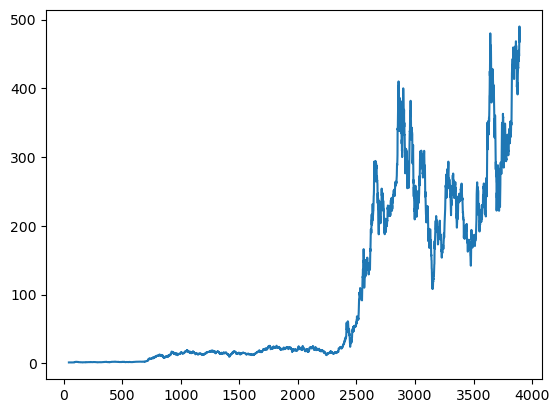

In [18]:
# Lets examine the Environment of our Study
plt.plot(df["Close"])
# As we can see, more often than not, the prices go up more than they go down 

In [19]:
df["Prediction"].value_counts()
# Down Days are rare, but they do stillm exist

Prediction
1    3467
0     383
Name: count, dtype: int64